# Pairs Trading
This strategy uses a Kalman filter to calculate the spread between two already-selected cointegrated stocks. We then use the spread to make trading decisions.

In [92]:
from datetime import datetime, timedelta
import logging

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
import pandas as pd
import numpy as np

import statsmodels.api as sm
from talib import ATR, EMA, RSI
import matplotlib.pyplot as plt

from examples.data import (
    download_bars,
    separate_bars_by_symbol,
    split_multi_index_bars_train_test,
)

from bacta.backtester import EventBacktester, Order, Position
from bacta.utilities import dash
from bacta.utilities.logger import get_logger, set_log_level

set_log_level(logging.DEBUG)

Cointegrated pairs are selected in a different notebook.

In [93]:
# we already know these are cointegrated
symbols = ["CMS", "DTE"]

bars = download_bars(
    symbols,
    start_date=datetime(2024, 7, 31),
    end_date=datetime(2025, 7, 31),
    timeframe=TimeFrame(1, TimeFrameUnit.Hour)
)
# split the bars into train and test
train_bars, test_bars = split_multi_index_bars_train_test(
    bars, split_ratio=0.9)

# get c
close_prices = train_bars["close"].unstack(level=0)

[2025-08-09 16:26:45][DEBUG] Loading data/CMSDTE_2024-07-31_2025-07-31_1Hour.pkl


We use a Kalman filter to compute the rolling hedge ratio between the two selected stocks.

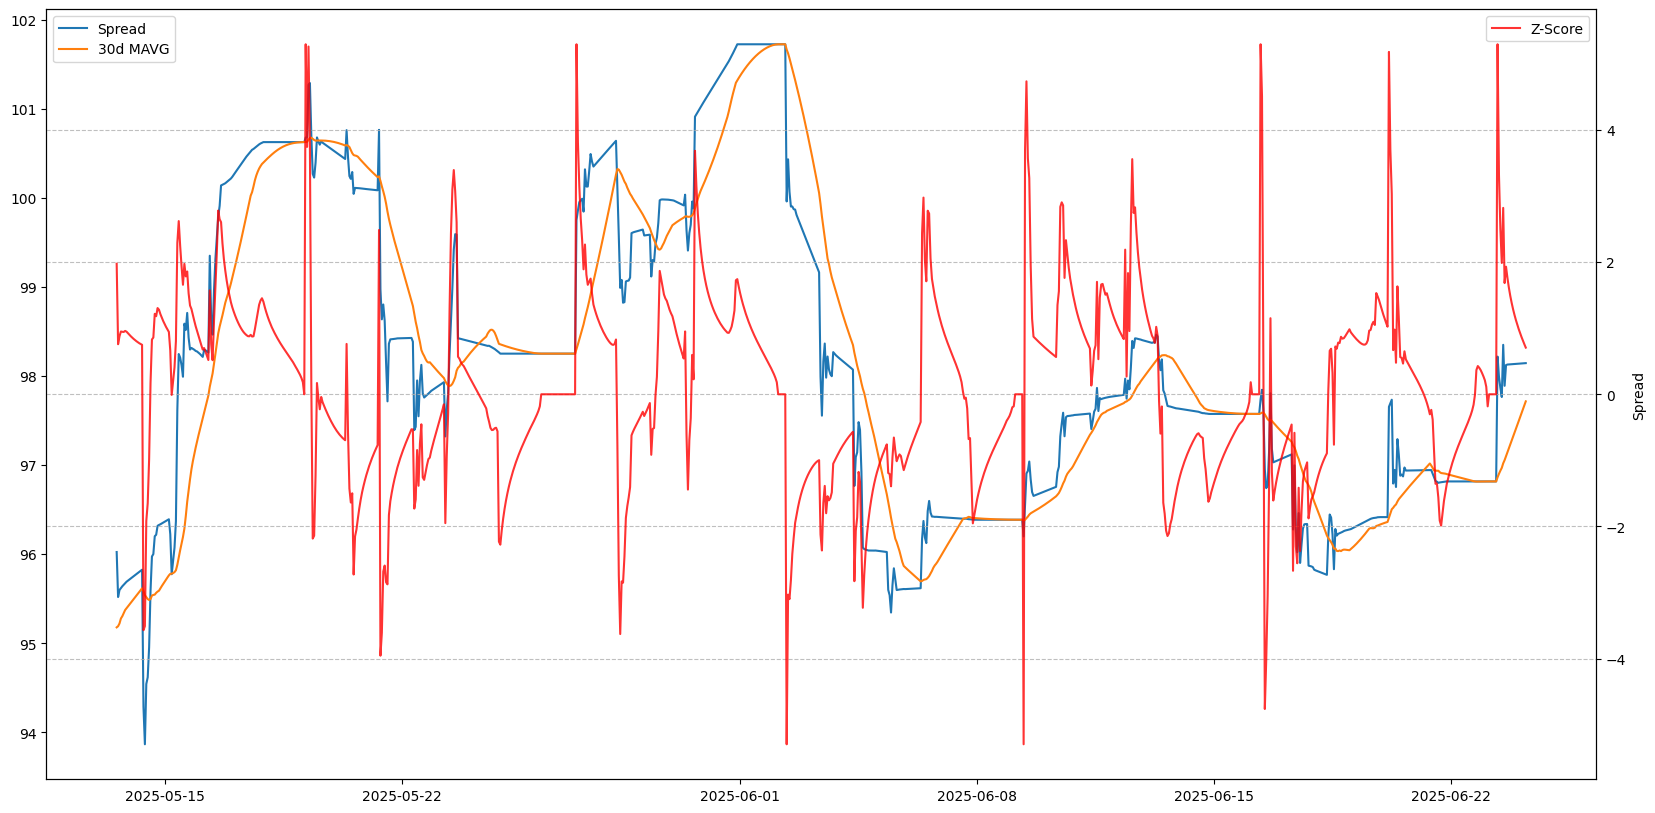

In [94]:
# Get the spread between the 2 stocks
# Calculate rolling beta coefficient
S1 = close_prices[symbols[0]]
S2 = close_prices[symbols[1]]
window = 30
rolling_beta = [np.nan] * window
for n in range(window, len(S1)):
    y = S1[(n - window):n]
    X = S2[(n - window):n]
    rolling_beta.append(sm.OLS(y, X).fit().params.iloc[0])

rolling_beta = pd.Series(rolling_beta, index=S2.index)

spread = S2 - rolling_beta * S1
spread.name = 'spread'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(window=window).mean()
spread_mavg30.name = 'spread 30d mavg'
# Take a rolling 30 day standard deviation
std_30 = spread.rolling(window=window).std()
std_30.name = 'std 30d'
# Calculate the z-score
zscore = (spread - spread_mavg30) / std_30
zscore = zscore.fillna(0) # for when spread = 0
zscore.name = 'zscore'

fig = plt.figure(figsize=(20, 10))
tail = 1000
plt.plot(spread.index[-tail:], spread.values[-tail:], label='Spread')
plt.plot(spread_mavg30.index[-tail:], spread_mavg30.values[-tail:], label='30d MAVG')
plt.legend(loc='upper left')

# also plot the zscore with secondary y axis
ax2 = plt.twinx()
ax2.plot(zscore.index[-tail:], zscore.values[-tail:], color='red', label='Z-Score', alpha=0.8)
plt.legend(loc='upper right')
ax2.set_ylabel('Z-Score')
plt.ylabel('Spread');
plt.grid(linestyle='--', alpha=0.8)
plt.show()

Make a backtester that uses the zscore to make trading decisions. We will have to recompute all values each new bar (so in the _update_state method).

In [ ]:
class PairsStrategy(EventBacktester):
    """
    Backtester that uses the pairs trading strategy.
    """

    def __init__(self, active_symbols, cash, **kwargs):
        super().__init__(active_symbols, cash, **kwargs)
        self.window = 30
        self.rolling_stats = pd.DataFrame(columns=["spread", "spread_mavg30", "std_30", "zscore"])
        

    def precompute_step(self, bars: pd.DataFrame):
        """
        Preload the indicators for the backtest.
        """
        close_prices = bars["close"].unstack(level=0)
        S1 = close_prices[self.active_symbols[0]]
        S2 = close_prices[self.active_symbols[1]]
        rolling_beta = [np.nan] * self.window
        for n in range(self.window, len(S1)):
            y = S1[(n - self.window):n]
            X = S2[(n - self.window):n]
            rolling_beta.append(sm.OLS(y, X).fit().params.iloc[0])

        # set the rolling beta to the last value
        self.rolling_beta = pd.Series(rolling_beta, index=S2.index)

        # Compute the rolling stats as new rows and append to self.rolling_stats
        spread = S2 - self.rolling_beta * S1
        spread_mavg30 = spread.rolling(window=self.window).mean()
        std_30 = spread.rolling(window=self.window).std()
        zscore = (spread - spread_mavg30) / std_30
        zscore = zscore.fillna(0)  # for when spread = 0

        # Create a DataFrame with the new stats
        self.rolling_stats = pd.DataFrame({
            "spread": spread,
            "spread_mavg30": spread_mavg30,
            "std_30": std_30,
            "zscore": zscore
        }, index=spread.index)

    def update_step(self, bars: pd.DataFrame, index: pd.Timestamp):
        """
        Update the state of the backtester.
        """
        close_prices = bars["close"].unstack(level=0) # these are the full bars
        S1 = close_prices[self.active_symbols[0]]
        S2 = close_prices[self.active_symbols[1]]

        spread = S2 - self.rolling_beta * S1
        
        
        self.rolling_beta = pd.concat([self.rolling_beta, pd.Series(sm.OLS(S1, S2).fit().params.iloc[0], index=[index])])

        
    def generate_orders(self, bar: pd.DataFrame, index: pd.Timestamp) -> list[Order]:
        """
        Make a decision based on the prices.
        """
        close_prices = bar.loc[:, "close"]
        # if zscore is > 1, then sell the pair
        # if zscore is < -1, then buy the pair
        # if zscore is between -1 and 1, then do nothing
        orders = []

        s1_quantity = 80 / close_prices[self.active_symbols[0]]
        s2_quantity = 80 / close_prices[self.active_symbols[1]]

        if self.rolling_stats.iloc[-1]["zscore"] > 1:
            orders.append(Order(self.active_symbols[1], Position.SHORT, close_prices[self.active_symbols[1]], s2_quantity))
            orders.append(Order(self.active_symbols[0], Position.LONG, close_prices[self.active_symbols[0]], s1_quantity))
        elif self.rolling_stats.iloc[-1]["zscore"] < -1:
            orders.append(Order(self.active_symbols[1], Position.LONG, close_prices[self.active_symbols[1]], s2_quantity))
            orders.append(Order(self.active_symbols[0], Position.SHORT, close_prices[self.active_symbols[0]], s1_quantity))
        return orders


In [96]:
# create the backtester
backtester = PairsStrategy(
    symbols,
    cash=2000,
    allow_short=True,
    min_cash_balance=100,
    max_short_value=2000,
    min_trade_value=1,
    market_hours_only=True,
    transaction_cost=0.000,
    transaction_cost_type="percentage",
)

# preload the train bars
backtester.load_train_bars(train_bars)

# run_backtest the backtest
backtester.run_backtest(test_bars)


[2025-08-09 16:26:47][DEBUG] Initializing backtester with active symbols: ['CMS', 'DTE'], cash: 2000, allow_short: True, min_cash_balance: 100, max_short_value: 2000, min_trade_value: 1, market_hours_only: True
[2025-08-09 16:26:48][INFO] Train bars have been previously loaded. Concatenating with test bars...
[2025-08-09 16:26:48][INFO] Running backtest over 9619 bars from 2025-06-24 06:00:00-04:00 to 2025-07-30 16:00:00-04:00...


                              spread  spread_mavg30    std_30    zscore
timestamp                                                              
2024-07-31 09:00:00-04:00        NaN            NaN       NaN  0.000000
2024-07-31 10:00:00-04:00        NaN            NaN       NaN  0.000000
2024-07-31 11:00:00-04:00        NaN            NaN       NaN  0.000000
2024-07-31 12:00:00-04:00        NaN            NaN       NaN  0.000000
2024-07-31 13:00:00-04:00        NaN            NaN       NaN  0.000000
...                              ...            ...       ...       ...
2025-06-24 01:00:00-04:00  98.140451      97.539343  0.650581  0.923957
2025-06-24 02:00:00-04:00  98.141665      97.583492  0.644799  0.865655
2025-06-24 03:00:00-04:00  98.142877      97.627681  0.635836  0.810265
2025-06-24 04:00:00-04:00  98.144087      97.671911  0.623544  0.757245
2025-06-24 05:00:00-04:00  98.145294      97.716181  0.607714  0.706110

[7869 rows x 4 columns]


Backtesting:   2%|▏         | 19/875 [00:00<00:04, 183.03it/s]

                           spread  spread_mavg30  std_30  zscore
timestamp                                                       
2024-07-31 09:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 10:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 11:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 12:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 13:00:00-04:00     NaN            NaN     NaN     0.0
...                           ...            ...     ...     ...
2025-07-30 12:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 13:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 14:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 15:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 16:00:00-04:00     NaN            NaN     NaN     0.0

[8744 rows x 4 columns]
                           spread  spread_mavg30  std_30  zscore
timestamp                                                       


Backtesting:   7%|▋         | 57/875 [00:00<00:04, 175.88it/s]

                           spread  spread_mavg30  std_30  zscore
timestamp                                                       
2024-07-31 09:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 10:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 11:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 12:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 13:00:00-04:00     NaN            NaN     NaN     0.0
...                           ...            ...     ...     ...
2025-07-30 12:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 13:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 14:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 15:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 16:00:00-04:00     NaN            NaN     NaN     0.0

[8744 rows x 4 columns]
                           spread  spread_mavg30  std_30  zscore
timestamp                                                       


Backtesting:  11%|█         | 92/875 [00:00<00:05, 148.80it/s]

                           spread  spread_mavg30  std_30  zscore
timestamp                                                       
2024-07-31 09:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 10:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 11:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 12:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 13:00:00-04:00     NaN            NaN     NaN     0.0
...                           ...            ...     ...     ...
2025-07-30 12:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 13:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 14:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 15:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 16:00:00-04:00     NaN            NaN     NaN     0.0

[8744 rows x 4 columns]
                           spread  spread_mavg30  std_30  zscore
timestamp                                                       


Backtesting:  12%|█▏        | 108/875 [00:00<00:05, 135.87it/s]

                           spread  spread_mavg30  std_30  zscore
timestamp                                                       
2024-07-31 09:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 10:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 11:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 12:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 13:00:00-04:00     NaN            NaN     NaN     0.0
...                           ...            ...     ...     ...
2025-07-30 12:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 13:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 14:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 15:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 16:00:00-04:00     NaN            NaN     NaN     0.0

[8744 rows x 4 columns]
                           spread  spread_mavg30  std_30  zscore
timestamp                                                       


Backtesting:  14%|█▍        | 122/875 [00:00<00:05, 132.63it/s]

                           spread  spread_mavg30  std_30  zscore
timestamp                                                       
2024-07-31 09:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 10:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 11:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 12:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 13:00:00-04:00     NaN            NaN     NaN     0.0
...                           ...            ...     ...     ...
2025-07-30 12:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 13:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 14:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 15:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 16:00:00-04:00     NaN            NaN     NaN     0.0

[8744 rows x 4 columns]
                           spread  spread_mavg30  std_30  zscore
timestamp                                                       


Backtesting:  17%|█▋        | 148/875 [00:01<00:08, 88.69it/s] 

                           spread  spread_mavg30  std_30  zscore
timestamp                                                       
2024-07-31 09:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 10:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 11:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 12:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 13:00:00-04:00     NaN            NaN     NaN     0.0
...                           ...            ...     ...     ...
2025-07-30 12:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 13:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 14:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 15:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 16:00:00-04:00     NaN            NaN     NaN     0.0

[8744 rows x 4 columns]
                           spread  spread_mavg30  std_30  zscore
timestamp                                                       


Backtesting:  18%|█▊        | 158/875 [00:01<00:09, 79.24it/s]

                           spread  spread_mavg30  std_30  zscore
timestamp                                                       
2024-07-31 09:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 10:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 11:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 12:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 13:00:00-04:00     NaN            NaN     NaN     0.0
...                           ...            ...     ...     ...
2025-07-30 12:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 13:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 14:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 15:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 16:00:00-04:00     NaN            NaN     NaN     0.0

[8744 rows x 4 columns]
                           spread  spread_mavg30  std_30  zscore
timestamp                                                       


Backtesting:  19%|█▉        | 167/875 [00:01<00:09, 72.33it/s]

                           spread  spread_mavg30  std_30  zscore
timestamp                                                       
2024-07-31 09:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 10:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 11:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 12:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 13:00:00-04:00     NaN            NaN     NaN     0.0
...                           ...            ...     ...     ...
2025-07-30 12:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 13:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 14:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 15:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 16:00:00-04:00     NaN            NaN     NaN     0.0

[8744 rows x 4 columns]
                           spread  spread_mavg30  std_30  zscore
timestamp                                                       


Backtesting:  21%|██        | 182/875 [00:01<00:10, 63.20it/s]

                           spread  spread_mavg30  std_30  zscore
timestamp                                                       
2024-07-31 09:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 10:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 11:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 12:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 13:00:00-04:00     NaN            NaN     NaN     0.0
...                           ...            ...     ...     ...
2025-07-30 12:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 13:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 14:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 15:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 16:00:00-04:00     NaN            NaN     NaN     0.0

[8744 rows x 4 columns]
                           spread  spread_mavg30  std_30  zscore
timestamp                                                       


                           spread  spread_mavg30  std_30  zscore
timestamp                                                       
2024-07-31 09:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 10:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 11:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 12:00:00-04:00     NaN            NaN     NaN     0.0
2024-07-31 13:00:00-04:00     NaN            NaN     NaN     0.0
...                           ...            ...     ...     ...
2025-07-30 12:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 13:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 14:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 15:00:00-04:00     NaN            NaN     NaN     0.0
2025-07-30 16:00:00-04:00     NaN            NaN     NaN     0.0

[8744 rows x 4 columns]
                           spread  spread_mavg30  std_30  zscore
timestamp                                                       


KeyboardInterrupt: 